# MovieLens Dataset

This notebook is a part of [Pandas tutorial](http://gregreda.com/2013/10/26/intro-to-pandas-data-structures/) by [Greg Reda](http://www.gregreda.com).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

To show pandas in a more "applied" sense, let's use it to answer some questions about the [MovieLens](http://www.grouplens.org/datasets/movielens/) dataset. Recall that we've already read our data into DataFrames and merged it.

In [2]:
# pass in column names for each CSV
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('data/ml-100k/u.user', sep='|', names=u_cols,
                    encoding='latin-1')

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('data/ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

# the movies file contains columns indicating the movie's genres
# let's only load the first five columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('data/ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),
                     encoding='latin-1')

# create one merged DataFrame
movie_ratings = pd.merge(movies, ratings)
lens = pd.merge(movie_ratings, users)

**What are the 25 most rated movies?**

In [3]:
most_rated = lens.groupby('title').size().sort_values(ascending=False)[:25]
most_rated

title
Star Wars (1977)                             583
Contact (1997)                               509
Fargo (1996)                                 508
Return of the Jedi (1983)                    507
Liar Liar (1997)                             485
English Patient, The (1996)                  481
Scream (1996)                                478
Toy Story (1995)                             452
Air Force One (1997)                         431
Independence Day (ID4) (1996)                429
Raiders of the Lost Ark (1981)               420
Godfather, The (1972)                        413
Pulp Fiction (1994)                          394
Twelve Monkeys (1995)                        392
Silence of the Lambs, The (1991)             390
Jerry Maguire (1996)                         384
Chasing Amy (1997)                           379
Rock, The (1996)                             378
Empire Strikes Back, The (1980)              367
Star Trek: First Contact (1996)              365
Back to the Fu

There's a lot going on in the code above, but it's very idomatic. We're splitting the DataFrame into groups by movie title and applying the `size` method to get the count of records in each group. Then we order our results in descending order and limit the output to the top 25 using Python's slicing syntax.

In SQL, this would be equivalent to:

    SELECT title, count(1)
    FROM lens
    GROUP BY title
    ORDER BY 2 DESC
    LIMIT 25;

Alternatively, pandas has a nifty `value_counts` method — yes, this is simpler — the goal above was to show a basic `groupby` example.

In [4]:
lens.title.value_counts()[:25]

Star Wars (1977)                             583
Contact (1997)                               509
Fargo (1996)                                 508
Return of the Jedi (1983)                    507
Liar Liar (1997)                             485
English Patient, The (1996)                  481
Scream (1996)                                478
Toy Story (1995)                             452
Air Force One (1997)                         431
Independence Day (ID4) (1996)                429
Raiders of the Lost Ark (1981)               420
Godfather, The (1972)                        413
Pulp Fiction (1994)                          394
Twelve Monkeys (1995)                        392
Silence of the Lambs, The (1991)             390
Jerry Maguire (1996)                         384
Chasing Amy (1997)                           379
Rock, The (1996)                             378
Empire Strikes Back, The (1980)              367
Star Trek: First Contact (1996)              365
Back to the Future (

**Which movies are most highly rated?**

In [5]:
movie_stats = lens.groupby('title').agg({'rating': [np.size, np.mean]})
movie_stats.head()

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000
101 Dalmatians (1996)        109  2.908257
12 Angry Men (1957)          125  4.344000
187 (1997)                    41  3.024390

We can use the `agg` method to pass a dictionary specifying the columns to aggregate (as keys) and a list of functions we'd like to apply.

Let's sort the resulting DataFrame so that we can see which movies have the highest average score.

In [6]:
# sort by rating average
movie_stats.sort_values([('rating', 'mean')], ascending=False).head()

rating     
                                             size mean
title                                                 
They Made Me a Criminal (1939)                  1  5.0
Marlene Dietrich: Shadow and Light (1996)       1  5.0
Saint of Fort Washington, The (1993)            2  5.0
Someone Else's America (1995)                   1  5.0
Star Kid (1997)                                 3  5.0

Because `movie_stats` is a DataFrame, we use the `sort` method — only Series objects use `order`. Additionally, because our columns are now a [MultiIndex](http://pandas.pydata.org/pandas-docs/stable/indexing.html#hierarchical-indexing-multiindex), we need to pass in a tuple specifying how to sort.

The above movies are rated so rarely that we can't count them as quality films. Let's only look at movies that have been rated at least 100 times.

In [7]:
atleast_100 = movie_stats['rating']['size'] >= 100
movie_stats[atleast_100].sort_values([('rating', 'mean')], ascending=False)[:15]

rating          
                                         size      mean
title                                                  
Close Shave, A (1995)                     112  4.491071
Schindler's List (1993)                   298  4.466443
Wrong Trousers, The (1993)                118  4.466102
Casablanca (1942)                         243  4.456790
Shawshank Redemption, The (1994)          283  4.445230
Rear Window (1954)                        209  4.387560
Usual Suspects, The (1995)                267  4.385768
Star Wars (1977)                          583  4.358491
12 Angry Men (1957)                       125  4.344000
Citizen Kane (1941)                       198  4.292929
To Kill a Mockingbird (1962)              219  4.292237
One Flew Over the Cuckoo's Nest (1975)    264  4.291667
Silence of the Lambs, The (1991)          390  4.289744
North by Northwest (1959)                 179  4.284916
Godfather, The (1972)                     413  4.283293

Those results look realistic.  Notice that we used boolean indexing to filter our `movie_stats` frame.

We broke this question down into many parts, so here's the Python needed to get the 15 movies with the highest average rating, requiring that they had at least 100 ratings:

```python
    movie_stats = lens.groupby('title').agg({'rating': [np.size, np.mean]})
    atleast_100 = movie_stats['rating'].size >= 100
    movie_stats[atleast_100].sort_values([('rating', 'mean')], ascending=False)[:15]
```

The SQL equivalent would be:

    SELECT title, COUNT(1) size, AVG(rating) mean
    FROM lens
    GROUP BY title
    HAVING COUNT(1) >= 100
    ORDER BY 3 DESC
    LIMIT 15;

**Limiting our population going forward**

Going forward, let's only look at the 50 most rated movies. Let's make a Series of movies that meet this threshold so we can use it for filtering later.

In [8]:
most_50 = lens.groupby('movie_id').size().sort_values(ascending=False)[:50]

The SQL to match this would be:

    CREATE TABLE most_50 AS (
        SELECT movie_id, COUNT(1)
        FROM lens
        GROUP BY movie_id
        ORDER BY 2 DESC
        LIMIT 50
    );
    
This table would then allow us to use EXISTS, IN, or JOIN whenever we wanted to filter our results. Here's an example using EXISTS:

    SELECT *
    FROM lens
    WHERE EXISTS (SELECT 1 FROM most_50 WHERE lens.movie_id = most_50.movie_id);

**Which movies are most controversial amongst different ages?**

Let's look at how these movies are viewed across different age groups. First, let's look at how age is distributed amongst our users.

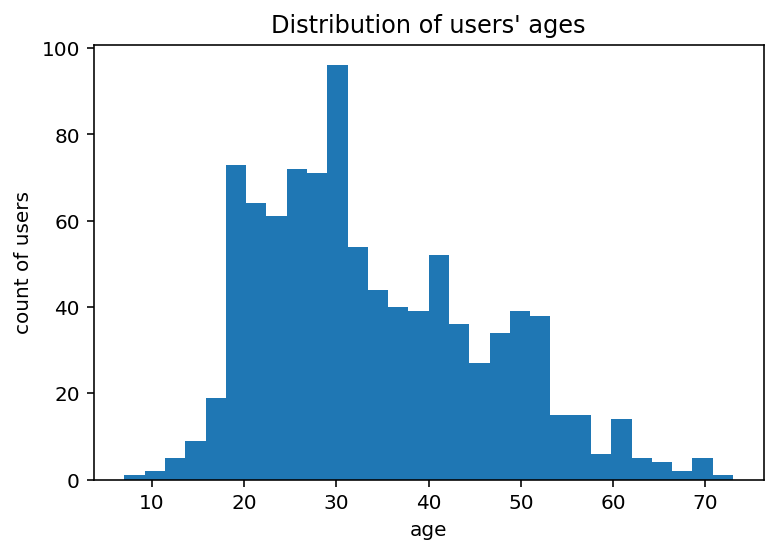

In [9]:
users.age.plot.hist(bins=30)
plt.title("Distribution of users' ages")
plt.ylabel('count of users')
plt.xlabel('age');

Pandas' integration with [matplotlib](http://matplotlib.org/index.html) makes basic graphing of Series/DataFrames trivial.  In this case, just call `hist` on the column to produce a histogram.  We can also use [matplotlib.pyplot](http://matplotlib.org/users/pyplot_tutorial.html) to customize our graph a bit (always label your axes).

**Binning our users**

I don't think it'd be very useful to compare individual ages — let's bin our users into age groups using `pandas.cut`.

In [10]:
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
lens['age_group'] = pd.cut(lens.age, range(0, 81, 10), right=False, labels=labels)
lens[['age', 'age_group']].drop_duplicates()[:10]

,age,age_group
0,60,60-69
397,21,20-29
459,33,30-39
524,30,30-39
782,23,20-29
995,29,20-29
1229,26,20-29
1664,31,30-39
1942,24,20-29
2270,32,30-39


`pandas.cut` allows you to bin numeric data. In the above lines, we first created labels to name our bins, then split our users into eight bins of ten years (0-9, 10-19, 20-29, etc.). Our use of `right=False` told the function that we wanted the bins to be *exclusive* of the max age in the bin (e.g. a 30 year old user gets the 30s label).

Now we can now compare ratings across age groups.

In [11]:
lens.groupby('age_group').agg({'rating': [np.size, np.mean]})

rating          
            size      mean
age_group                 
0-9           43  3.767442
10-19       8181  3.486126
20-29      39535  3.467333
30-39      25696  3.554444
40-49      15021  3.591772
50-59       8704  3.635800
60-69       2623  3.648875
70-79        197  3.649746

Young users seem a bit more critical than other age groups. Let's look at how the 50 most rated movies are viewed across each age group. We can use the `most_50` Series we created earlier for filtering.

In [12]:
lens.set_index('movie_id', inplace=True)

In [13]:
by_age = lens.loc[most_50.index].groupby(['title', 'age_group'])
by_age.rating.mean().head(15)

title                 age_group
Air Force One (1997)  0-9               NaN
                      10-19        3.647059
                      20-29        3.666667
                      30-39        3.570000
                      40-49        3.555556
                      50-59        3.750000
                      60-69        3.666667
                      70-79        3.666667
Alien (1979)          0-9               NaN
                      10-19        4.111111
                      20-29        4.026087
                      30-39        4.103448
                      40-49        3.833333
                      50-59        4.272727
                      60-69        3.500000
Name: rating, dtype: float64

Notice that both the title and age group are indexes here, with the average rating value being a Series. This is going to produce a really long list of values.

Wouldn't it be nice to see the data as a table? Each title as a row, each age group as a column, and the average rating in each cell.

Behold! The magic of `unstack`!

In [14]:
by_age.rating.mean().unstack(1).fillna(0)[10:20]

age_group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79
title,,,,,,,,
E.T. the Extra-Terrestrial (1982),0.0,3.680000,3.609091,3.806818,4.160000,4.368421,4.375000,0.000000
"Empire Strikes Back, The (1980)",4.0,4.642857,4.311688,4.052083,4.100000,3.909091,4.250000,5.000000
"English Patient, The (1996)",5.0,3.739130,3.571429,3.621849,3.634615,3.774648,3.904762,4.500000
Fargo (1996),0.0,3.937500,4.010471,4.230769,4.294118,4.442308,4.000000,4.333333
Forrest Gump (1994),5.0,4.047619,3.785714,3.861702,3.847826,4.000000,3.800000,0.000000
"Fugitive, The (1993)",0.0,4.320000,3.969925,3.981481,4.190476,4.240000,3.666667,0.000000
"Full Monty, The (1997)",0.0,3.421053,4.056818,3.933333,3.714286,4.146341,4.166667,3.500000
"Godfather, The (1972)",0.0,4.400000,4.345070,4.412844,3.929412,4.463415,4.125000,0.000000
Groundhog Day (1993),0.0,3.476190,3.798246,3.786667,3.851064,3.571429,3.571429,4.000000


`unstack`, well, unstacks the specified level of a [MultiIndex](http://pandas.pydata.org/pandas-docs/stable/indexing.html#hierarchical-indexing-multiindex) (by default, `groupby` turns the grouped field into an index — since we grouped by two fields, it became a MultiIndex). We unstacked the second index (remember that Python uses 0-based indexes), and then filled in NULL values with 0.

If we would have used:
```python
    by_age.rating.mean().unstack(0).fillna(0)
```
We would have had our age groups as rows and movie titles as columns.

**Which movies do men and women most disagree on?**

EDIT: *I realized after writing this question that Wes McKinney basically went through the exact same question in his book. It's a good, yet simple example of `pivot_table`, so I'm going to leave it here. Seriously though, [go buy the book](http://www.amazon.com/gp/product/1449319793/ref=as_li_tl?ie=UTF8&camp=1789&creative=390957&creativeASIN=1449319793&linkCode=as2&tag=gjreda-20&linkId=MCGW4C4NOBRVV5OC).*

Think about how you'd have to do this in SQL for a second. You'd have to use a combination of IF/CASE statements with aggregate functions in order to pivot your dataset. Your query would look something like this:

    SELECT title, AVG(IF(sex = 'F', rating, NULL)), AVG(IF(sex = 'M', rating, NULL))
    FROM lens
    GROUP BY title;
    
Imagine how annoying it'd be if you had to do this on more than two columns.
    
DataFrame's have a `pivot_table` method that makes these kinds of operations much easier (and less verbose).

In [15]:
lens.reset_index('movie_id', inplace=True)

In [16]:
pivoted = lens.pivot_table(index=['movie_id', 'title'],
                           columns=['sex'],
                           values='rating',
                           fill_value=0)
pivoted.head()

,sex,F,M
movie_id,title,,
1,Toy Story (1995),3.789916,3.909910
2,GoldenEye (1995),3.368421,3.178571
3,Four Rooms (1995),2.687500,3.108108
4,Get Shorty (1995),3.400000,3.591463
5,Copycat (1995),3.772727,3.140625


In [17]:
pivoted['diff'] = pivoted.M - pivoted.F
pivoted.head()

,sex,F,M,diff
movie_id,title,,,
1,Toy Story (1995),3.789916,3.909910,0.119994
2,GoldenEye (1995),3.368421,3.178571,-0.189850
3,Four Rooms (1995),2.687500,3.108108,0.420608
4,Get Shorty (1995),3.400000,3.591463,0.191463
5,Copycat (1995),3.772727,3.140625,-0.632102


In [18]:
pivoted.reset_index('movie_id', inplace=True)

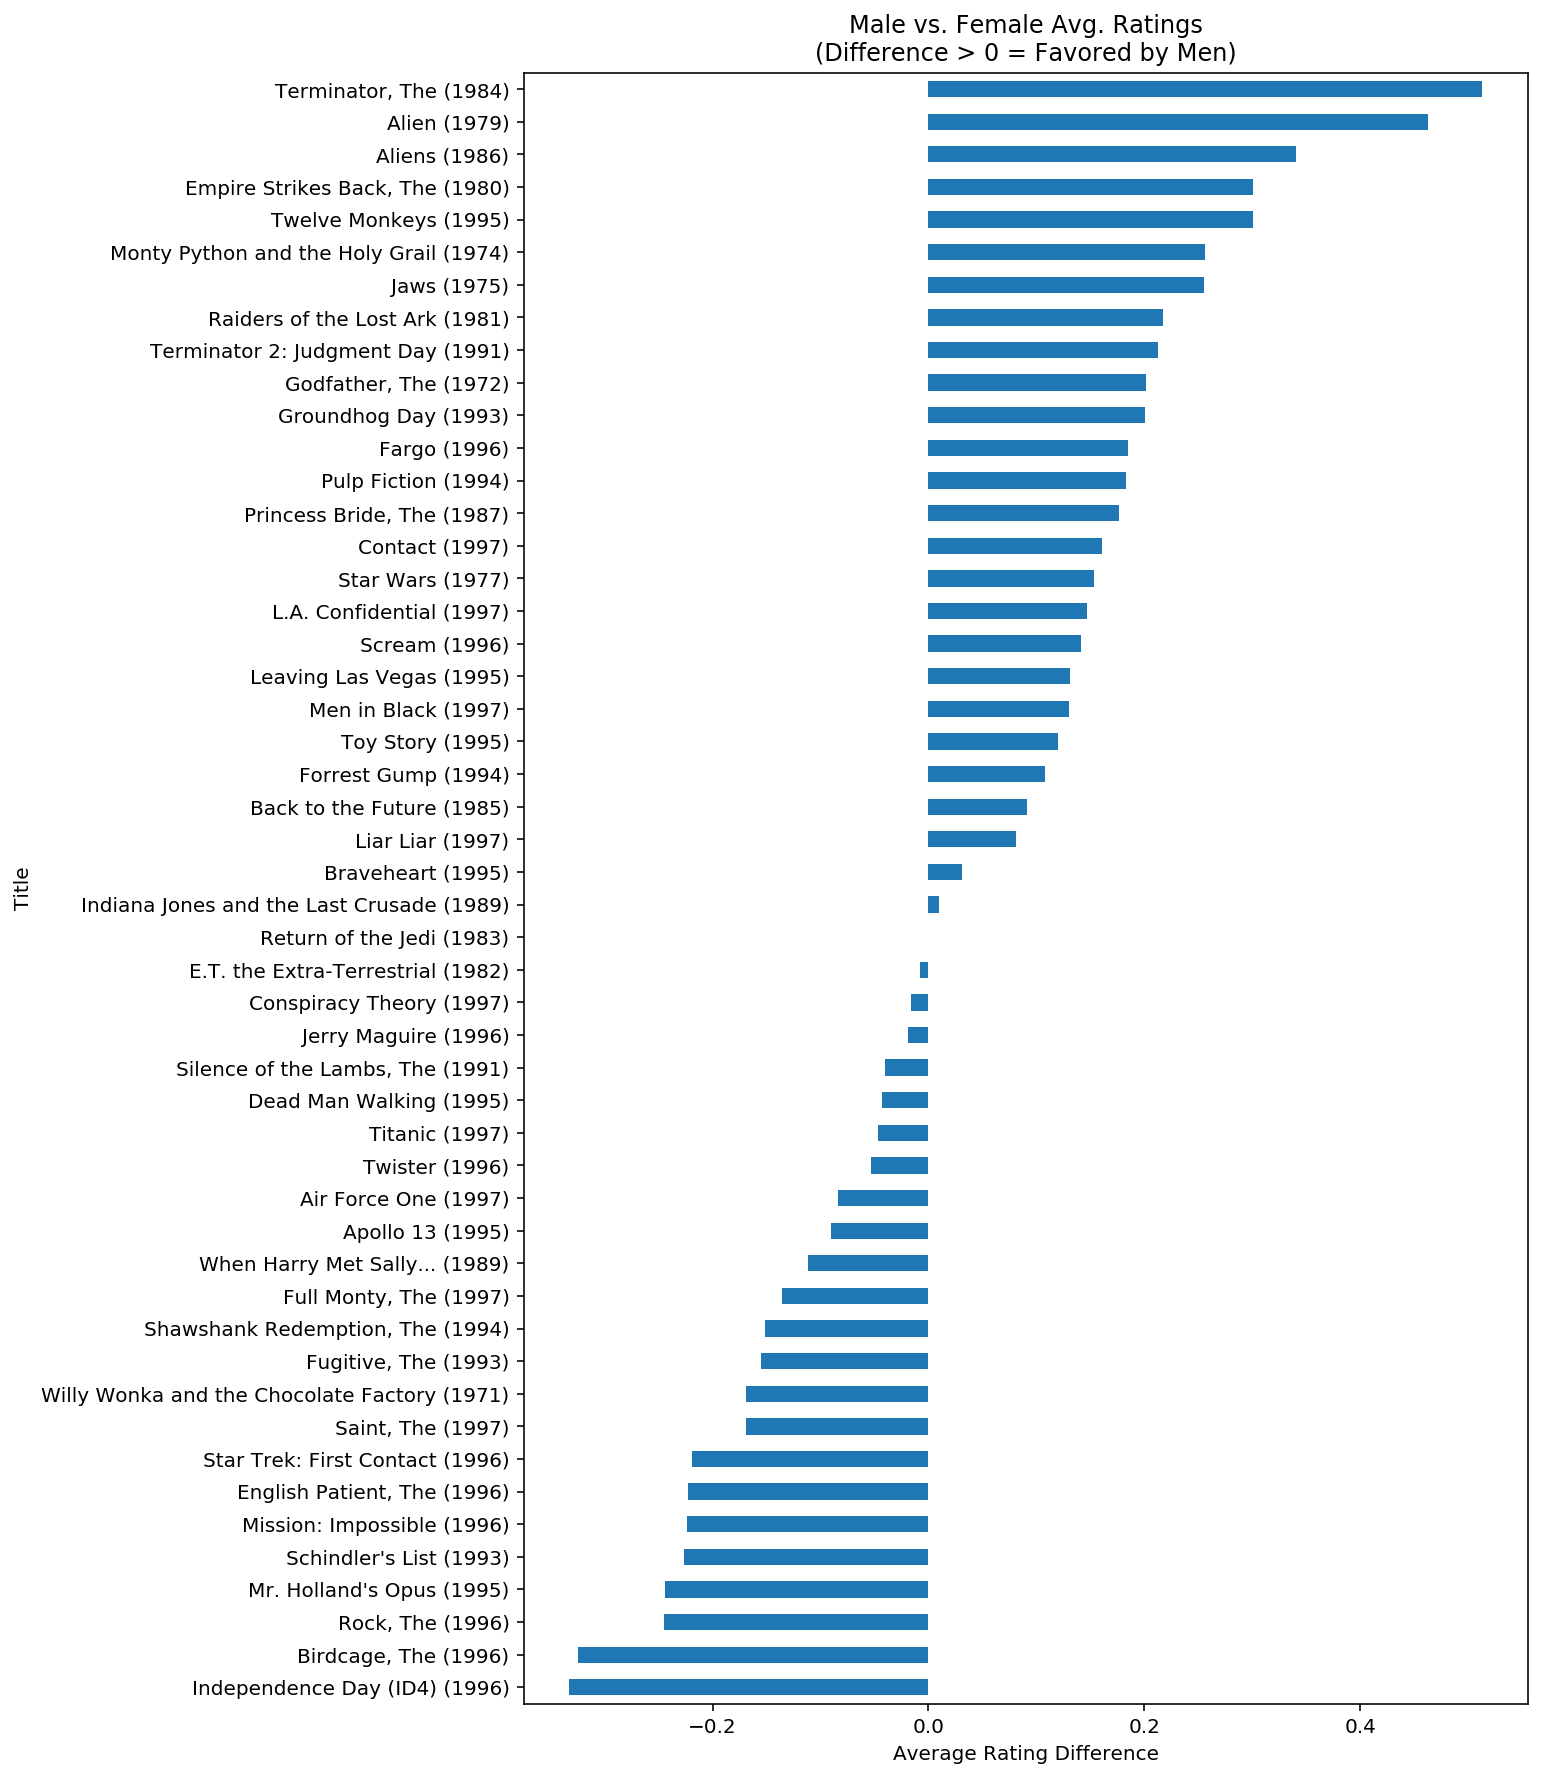

In [19]:
disagreements = pivoted[pivoted.movie_id.isin(most_50.index)]['diff']
disagreements.sort_values().plot(kind='barh', figsize=[9, 15])
plt.title('Male vs. Female Avg. Ratings\n(Difference > 0 = Favored by Men)')
plt.ylabel('Title')
plt.xlabel('Average Rating Difference');

## Further reading

Using pandas you can do any data manipulation you can do in excel or a database plus a whole lot more. The only limitation is that all the work must be able to be done in-memory on your computer.

You may have noticed the general process is to perform some manipulation and then call `df.head()` to see if you got what you want. In a real application you'll likely also be googling how to do certain operations or debug your error message, similar to a lot of other coding and analytical work.

* Check out more introductory notebooks in **Juno**!
* [Pandas documentation](http://pandas.pydata.org/pandas-docs/stable/) 
* [Introduction to pandas by Chris Fonnesbeck](http://nbviewer.ipython.org/urls/gist.github.com/fonnesbeck/5850375/raw/c18cfcd9580d382cb6d14e4708aab33a0916ff3e/1.+Introduction+to+Pandas.ipynb) 
* [Pandas videos from PyCon](http://pyvideo.org/search?models=videos.video&q=pandas)
* [Pandas and Python top 10](http://manishamde.github.io/blog/2013/03/07/pandas-and-python-top-10/)
* [Practical pandas by Tom Augspurger (one of the pandas developers)](http://tomaugspurger.github.io/categories/pandas.html)

## Versions

In [20]:
%reload_ext version_information

%version_information pandas, numpy, xlrd

Software versions
Python 3.6.6+ 64bit [GCC 4.2.1 Compatible Apple LLVM 10.0.1 (clang-1001.0.46.4)]
IPython 7.3.0
OS Darwin 18.7.0 x86_64 64bit
pandas 0.25.0
numpy 1.16.4
xlrd 1.2.0
Wed Sep 04 21:58:33 2019 BST